In [1]:
import matplotlib.pyplot as plt
import numpy as np
import onnxruntime as ort
import soundfile as sf
from onnxruntime.quantization import quantize_dynamic, quant_pre_process

from streamsad.feature_extractor import FeatureExtractor

In [2]:
model_fp32 = "../src/streamsad/models/model_2025-06-10.onnx"
model_pre = "model_2025-06-10_pre.onnx"
model_int8_dynamic = "model_2025-06-10_dynamic_int8.onnx"


quant_pre_process(model_fp32, model_pre)
quantized_model = quantize_dynamic(model_pre, model_int8_dynamic)

In [3]:
ort_session_fp32 = ort.InferenceSession(model_fp32)
ort_session_int8_dynamic = ort.InferenceSession(model_int8_dynamic)

In [4]:
x, fs = sf.read("../tests/data/George-crop2.wav")
feature_extractor = FeatureExtractor()
spect = feature_extractor(x)
state = np.zeros((1, 1, 64), dtype=np.float32)


In [5]:
%%timeit
raw_output_fp32, _ = ort_session_fp32.run(
    None,
    {"input": spect, "input_state": state},
)

290 µs ± 3.07 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [6]:
%%timeit
raw_output_int8_dynamic, _ = ort_session_int8_dynamic.run(
    None,
    {"input": spect, "input_state": state},
)

309 µs ± 4.73 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


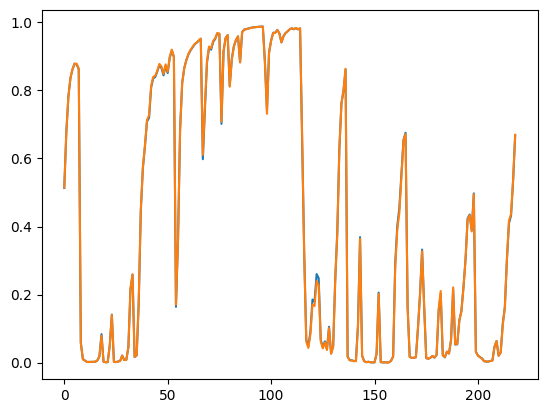

In [7]:
raw_output_fp32, _ = ort_session_fp32.run(
    None,
    {"input": spect, "input_state": state},
)
plt.plot(raw_output_fp32[0, ..., 0], label="FP32")

raw_output_int8_dynamic, _ = ort_session_int8_dynamic.run(
    None,
    {"input": spect, "input_state": state},
)
plt.plot(raw_output_int8_dynamic[0, ..., 0], label="INT8D")